In [1]:
import quspin as qs
import numpy as np
import matplotlib.pyplot as plt
from quspin.operators import hamiltonian # Hamiltonians and operators
from quspin.basis import spin_basis_1d # Hilbert space spin basis
from quspin.operators import quantum_operator
import math
from quspin.basis import spin_basis_general
from matplotlib import colors
import random
import time

In [3]:
pulse_time = 0.0478e-3 # in s
free_time = 15000 * pulse_time # 0.6e-3 # in s
rabi_frequency = 2*np.pi*(1/pulse_time)/4 # From RbCs Ramsey Paper https://doi.org/10.1088/2058-9565/aaee35 Figure 7
print((pulse_time*rabi_frequency)/(np.pi/2)) # Check pulse time and rabi frequency give a pi/2 pulse area 

0.9999999999999999


In [5]:
def intmatrix(Lx, J, xs=1, ys=1, theta=0, phi=0, Ly='_', plot=False):
    # define side length of simulated system as L
    if Lx % 2 == 1:
        pass
    else:
        Lx += 1

    if Ly == '_':
        Ly = Lx
    else:
        if Ly % 2 == 1:
            pass
        else:
            Ly += 1
    
    mat = np.zeros((Lx, Ly))
    
    L_xrange, L_yrange = range(Lx), range(Ly)
    center_xindex = int(L_xrange[-1]/2)
    center_yindex = int(L_yrange[-1]/2)
    
    
    center = np.array([xs*center_xindex, ys*center_yindex, 0]) #position of matrix center (in 3D)
    
    quan_axis = [np.cos(theta)*np.sin(phi), np.sin(theta)*np.sin(phi), np.cos(phi)] #quantization axis as an unit vector
    
    
    for i in L_xrange:
        for j in L_yrange:
            displacement = np.array([xs*i, ys*j, 0]) - center
            r = np.linalg.norm(displacement)
            angle = np.arccos(displacement @ quan_axis/r)
            mat[i, j] = J*(1-3*(np.cos(angle)**2))/(r**3)
    mat[center_xindex, center_yindex] = 0.0

    if plot == True:
        fig, ax = plt.subplots()

        mat, xside, yside = intmatrix(Lx, J, Ly=Ly, theta=theta, phi=phi)
        couplings = np.transpose(mat) #transpose to show x and y axis correctly (this will also switch x and y corrdinate ordering when indexing)

        cmap = plt.cm.RdBu
        ax.matshow(couplings, cmap=cmap, norm=colors.CenteredNorm())

        for i in range(len(couplings)):
            for j in range(len(couplings[0])): 
                c = '{:g}'.format(float('{:.2g}'.format(couplings[i, j])))
                #c = '(' + str(j) + ', ' + str(i) + ')'
                    
                ax.text(j, i, str(c), va='center', ha='center')
    
    return mat, Lx, Ly #indexing interaction matrix is done with mat[x coordinate, y coordinate]

def ran_occupied_sites(N, x, y): #dimensions of simulated lattice and no of particles to distribute
    total_sites = int(x*y)

    # Randomize which lattice sites are occupied
    occupied_sites = []
    free_sites = list(range(total_sites))
    
    for i in range(N):
        ran = random.randint(0, total_sites-i-1)
        #print('random int = ' + str(ran))
        occupied_sites.append(free_sites.pop(ran))
        
    return sorted(occupied_sites) #returns ordered list of N unique numbers between 0 and the total sites - 1 inclusive

def couples(sites, pairs, interactions, xy='_'):
    if xy == '_':    
        int_x, int_y = len(interactions)//2 + 1, len(interactions[0])//2 + 1 #dimensions of interaction matrix
    else:
        int_x, int_y = xy
    #use interaction matrix to get couplings between each occupied site and output this in the correct formatt with particle number
    couples = []
    for i in pairs:
        p1, p2 = sites[i[0]], sites[i[1]]
        
        couples.append([interactions[int_x - 1  + (p1 % int_x) - (p2 % int_x), int_y - 1 + (p1 // int_x) - (p2 // int_x)], i[0], i[1]]) 
    return couples

def pbc_couples(sites, pairs, interactions, xy='_'): #Constructs interaction strengths for periodic boundry conditions
    if xy == '_':    
        int_x, int_y = len(interactions)//2 + 1, len(interactions[0])//2 + 1 #centre of interaction matrix
    else:
        int_x, int_y = xy
    #use interaction matrix to get couplings between each occupied site and output this in the correct formatt with particle number
    couples = []
    for i in pairs:
        p1, p2 = sites[i[0]], sites[i[1]]
        dx, dy = (p1 % int_x) - (p2 % int_x), (p1 // int_x) - (p2 // int_x)
        
        if dx >= int_x:
            dx = dx - len(interactions)
        elif dx <= -int_x:
            dx = dx + len(interactions)
            
        if dy >= int_y:
            dy = dy - len(interactions[0])
        elif dy <= -int_y:
            dy = dy + len(interactions[0])
        
        couples.append([interactions[int_x - 1  + dx, int_y - 1 + dy], i[0], i[1]]) 
    return couples

def symm_mat(x, y, occupied_sites, basis, axis=1): #defult finds mirror plane transformation which flips x coordinates
    #only relevent if lattice simulated has the symmetry which is tested on basis staes
    #occupied sites labelled left to right up to down in basis
    #for rectangular simulated systems (but sites occupied can be picked)

    symm = np.zeros((len(basis), len(basis)))
    count1 = 0
    asymmetrics = []
    flips = []
    for i in basis:
        basis_on_lattice = np.zeros((x, y))
        count2 = 0
        for n in i:
            if n == 1:
                basis_on_lattice[occupied_sites[count2] % x, occupied_sites[count2] // x] = 1

            count2 += 1

        flipped = np.flip(basis_on_lattice, axis)
        
        
        if flipped == basis_on_lattice:
            symm[count1, count1] = 1
        else:
            asymmetrics.append(basis_on_lattice)
            flips.append(flipped)
        count1 += 1

    for state in asymmetrics:
        pair = np.where(flips == state)[0]
        symm[pair[0], pair[1]], symm[pair[1], pair[0]] = 1, 1

    return symm
    
def str_tens(A, B):
    new = []
    for i in A:
        for n in B:
            new.append(i + n)
    return new

def sparse_up_prob(L, row_len, col_len, populations):
    basis = spin_basis_general(N=L, pauli=False)
    #col_len = int(math.ceil(L/row_len))

    #contruct outer product of single particle up spin state operator to find the probability it is in up
    outer_products = []
    for i in range(L):
        factors = [[[0.5, i]], [[-1, i]]]
        opers = [['I', factors[0]], ['z', factors[1]]]
        input_dict = {'up': opers}
        outer_products.append(quantum_operator(input_dict, basis=basis))
        #__ = quantum_operator(input_dict, basis=basis).tohamiltonian()
        #print(__.toarray())


    #calculate the probability each particle is spin up for each time evolved
    results = []
    for i in np.transpose(populations):
        probs = []
        for n in range(L):
            probs.append(outer_products[n].expt_value(i))
        results.append(sum(probs)/L)

    #print(results)
    return results

#define pulse sequences
def pulse_ramsey(t, pulse_time, free_time, rabi_frequency):
    if t <= pulse_time:
        return rabi_frequency
    elif t < pulse_time + free_time:
        return 0 
    elif t <= 2 * pulse_time + free_time:
        return rabi_frequency
    else:
        return 0

def pulse_single(t, pulse_time, free_time, rabi_frequency):
    if t <= pulse_time:
        return rabi_frequency
    else:
        return 0

def no_pulse(t, pulse_time, free_time, rabi_frequency):
    return 0

def construct_H(N, J, det, ax, ay, Lx, params, pulse, theta=0, phi=0, Ly='_', int_plot=False, occupied_sites='_', pbc=False):
    basis = spin_basis_general(N=N, pauli=False)
    #print(basis)
    if Ly == '_':
        Ly = 1

    #construct interaction
    sites = range(N)
    pairs = [[i, k] for idx, i in enumerate(sites) for k in sites[idx + 1:]]
    
    #interaction strengths between each particle
    interaction_matrix, _, _ = intmatrix(Lx*2 - 1, 1, xs=ax, ys=ay, theta=theta, phi=phi, Ly=Ly*2 - 1, plot=int_plot) 
    #above outputs 3 variables (also set J=1 in this function as it xJ at the end anyway) 

    #determin sites that are occupied (random or not)
    if occupied_sites == '_':
        sites = ran_occupied_sites(N, Lx, Ly)
    else:
        sites = sorted(occupied_sites) #make sure occupied sites is the correct length with numbers under total sites

    
    #contruct infomation in to reqired format
    if pbc == True: #For periodic boundry conditions
        intr = pbc_couples(sites, pairs, interaction_matrix)
    else:    
        intr = couples(sites, pairs, interaction_matrix)
    
    #construct resonant and detuning terms
    drive = [[1.0, i] for i in range(N)]
    detuning = [[1.0, i] for i in range(N)]

    operator_list_0 = [['z', detuning]]
    operator_list_1 = [['x', drive]]

    #print(intr)

    #construct full Hamiltonian
    interaction = [['+-', intr], ['-+', intr]]
    operator_dict = {'detuning': operator_list_0, 'drive': operator_list_1, 'interaction': interaction}
    H = quantum_operator(operator_dict, basis=basis)
    params_dict = dict(detuning=det, drive=(pulse, params), interaction=J)
    H_lmbda1 = H.tohamiltonian(params_dict)
    return H_lmbda1

def ensemble_Ramsey(samples, time, p_max, r_max, initial_state, N, J, det, ax, ay, params, pulse, theta=0, phi=0):
    results = []
    for i in range(samples):
        r = random.randint(0, int(3000*r_max/4))/1000
        p = p_max*(1 - (r/r_max)**2)
        side_length = int(np.sqrt(N/p))+1
        #print(side_length)
        #side_length = 2
        Hamiltonian = construct_H(N, J, det, ax, ay, side_length, params, pulse, theta=theta, phi=phi, Ly=side_length)
        populations = Hamiltonian.evolve(initial_state, 0, time)
        ups = sparse_up_prob(N, L, L, populations)
        results.append(ups[-1])
        #print('Sample ' + str(i) + ' completed')
    return sum(results)/samples

Hermiticity check passed!
Symmetry checks passed!


C:\Users\Joe\AppData\Local\Temp\ipykernel_6336\3938601720.py:32: RuntimeWarning: invalid value encountered in scalar divide
  angle = np.arccos(displacement @ quan_axis/r)
C:\Users\Joe\AppData\Local\Temp\ipykernel_6336\3938601720.py:32: RuntimeWarning: invalid value encountered in scalar divide
  angle = np.arccos(displacement @ quan_axis/r)


Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


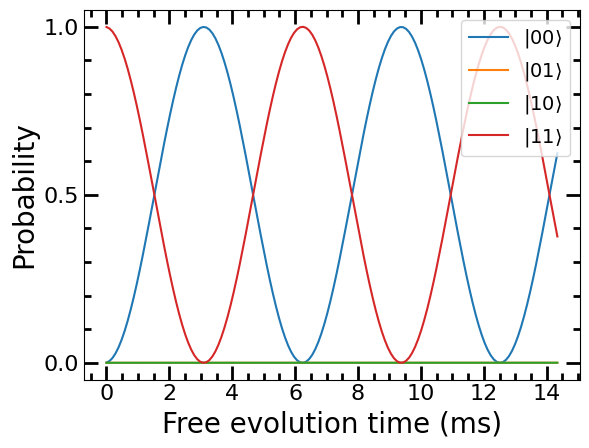

In [4]:
single_Ramsey_fringe = True
if single_Ramsey_fringe == True:
    start_time = time.time()

    intervals = 150
    holds = np.linspace(0, 300 * pulse_time, intervals)
    J = 1000
    L = 2
    row_len = L
    ax, ay = 1, 1
    
    psi_0 = np.zeros(2**L)
    psi_0[0] = 1 
    probs = []
    for free_time in holds:
        params = [pulse_time, free_time, rabi_frequency]
        H_lmb = construct_H(L, J, 0, ax, ay, row_len, params, pulse_ramsey)
        times = np.linspace(0, 2*pulse_time + free_time, 2)
        populations = H_lmb.evolve(psi_0, 0, times)
        #print(populations[0][-1])
        probs.append([abs(populations[0][-1])**2, abs(populations[1][-1])**2, abs(populations[2][-1])**2, abs(populations[3][-1])**2])
    print("--- %s seconds ---" % (time.time() - start_time))
    
    ket = [r'0', r'1']
    labels = [r'0', r'1']
    for i in range(L - 1):
        labels = str_tens(labels, ket)
    fig, axes = plt.subplots(1, 1)
    for i in range(2**L):
        axes.plot(holds*(10**3), [row[i] for row in probs], label='|' + labels[i] + r'$\rangle$')
        
        #for i in range(5):
            #print(populations[:,1][100*i])

    axes.set_ylabel(r"Probability", fontsize=20)
    axes.set_xlabel('Free evolution time (ms)', fontsize=20)
    axes.legend(loc=1, prop={'size': 14})

    axes.minorticks_on()
    axes.tick_params(which='major', length=10, width=2, direction='in', bottom=True, top=True, left=True, right=True)
    axes.tick_params(which='minor', length=5, width=2, direction='in', bottom=True, top=True, left=True, right=True)
    axes.set_yticks([0, 0.5, 1]) 
    plt.yticks(fontsize=16)
    plt.xticks(fontsize=16)
    plt.savefig(f'{L}_Particle_ramsey.png', bbox_inches='tight')
    
    plt.show(block=False)
    

In [68]:
start_time = time.time()

intervals = 200
holds = np.linspace(0, 350 * pulse_time, intervals)
samples = 1

particles_per_sample = 5
J, det, ax, ay = 1200, 0, 1, 1
p_max, r_max = 0.0544, 1000
theta, phi = 0, 0

initial_state = np.zeros(2**particles_per_sample)
initial_state[-1] = 1

up_probabilities = []
progress = 0
for i in holds:
    #time = [0, pulse_time, pulse_time + i, 2*pulse_time + i]
    times2 = np.linspace(0, 2*pulse_time + i, 2)
    params = [pulse_time, i, rabi_frequency]
    up_probabilities.append(ensemble_Ramsey(samples, times2, p_max, r_max, initial_state, particles_per_sample, J, det, ax, ay, params, pulse_ramsey, theta=theta, phi=phi))
    progress += 1
    print(str(progress) + '/' + str(intervals) + ' Done')
print("--- %s seconds ---" % (time.time() - start_time))

/var/folders/ln/c_qknrr51xbgxcyyp59605kr0000gn/T/ipykernel_88472/4166665165.py:32: RuntimeWarning: invalid value encountered in scalar divide
  angle = np.arccos(displacement @ quan_axis/r)


Hermiticity check passed!
Symmetry checks passed!


NameError: name 'L' is not defined

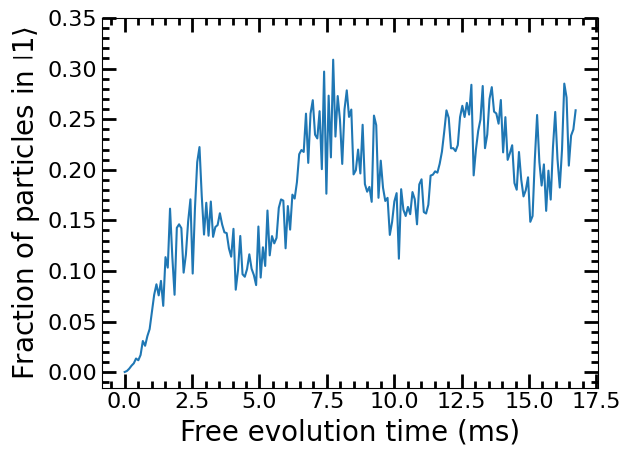

In [26]:
fig, axes = plt.subplots(1, 1)

axes.plot(holds*(10**3), up_probabilities)
        
    #for i in range(5):
        #print(populations[:,1][100*i])

axes.set_ylabel(r"Fraction of particles in $\left|1\right>$", fontsize=20)
axes.set_xlabel('Free evolution time (ms)', fontsize=20)

axes.minorticks_on()
axes.tick_params(which='major', length=10, width=2, direction='in', bottom=True, top=True, left=True, right=True)
axes.tick_params(which='minor', length=5, width=2, direction='in', bottom=True, top=True, left=True, right=True)
yticks = np.linspace(0, 0.35, 8)
axes.set_yticks(yticks) 
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.savefig(f'Ensemble_Ramsey_{particles_per_sample}_Particle_{samples}_samples_{J}Hz.png', bbox_inches='tight')
    
plt.show(block=False)

In [9]:
def generate_radial_distribution(lattice_filling_max, r_max):
    def generator_dist(r):
        return lattice_filling_max*(1 - (r/r_max)**2)
    return generator_dist

def generate_uniform_distribution(lattice_filling):
    def uniform_dist(r):
        return lattice_filling
    return uniform_dist

def prob_mat(function, lattice_dimensions, samples=1, ax=1, ay=1, polar=True):
    
    dist = np.zeros(lattice_dimensions)
    cen_x, cen_y = lattice_dimensions[0]/2, lattice_dimensions[1]/2
    
    cy = -cen_y
    for i in range(lattice_dimensions[1]):
        cx = -cen_x
        for n in range(lattice_dimensions[0]):
            sam_xpoints, sam_ypoints = np.linspace(cx - ax/2, cx + ax/2, samples + 1), np.linspace(cy - ay/2, cy + ay/2, samples + 1)

            if polar == True:
                values = []
                for u in sam_xpoints:
                    sam_radii = np.sqrt(u**2 + sam_ypoints**2)
                    values.append(function(sam_radii))
            ###################### next 'else' code is untested #####################
            else:
                values = []
                for u in sam_xpoints:
                    values.append(function(u, sam_ypoints))

            segments = 0
            for l in range(samples**2):
                avg_func = sum([values[ l % samples][ l // samples], values[ l % samples + 1][ l // samples], values[ l % samples][ l // samples + 1], values[ l % samples + 1][ l // samples + 1]])/4 
                segments += avg_func * (ax/samples) * (ay/samples)
            
            dist[n, i] = segments

            cx += ax
        cy += ay

    return dist

def unif_random_config(filling, N):
    side_length = int(np.sqrt(N/filling)) + 1
    positions = random.sample(range(1, side_length**2), N)
    config = np.zeros((side_length, side_length))
    for i in positions:
        config[i // side_length, i % side_length] = 1 
    return config

    

def unif_find_geometries(filling, N, samples):
    no = [[1]]
    pair = [[0, 0, 0, 0], [0, 1, 1, 0], [0, 0, 0, 0]]
    diag_pair = [[0, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 0]]
    sep_pair = [[0, 0, 0, 0, 0], [0, 1, 0, 1, 0], [0, 0, 0, 0, 0]]
    triangle = [[0, 0, 0, 0], [0, 1, 1, 0], [0, 1, 0, 0], [0, 0, 0, 0]]
    chain_3 = [[0, 0, 0, 0, 0], [0, 1, 1, 1, 0], [0, 0, 0, 0, 0]]
    chain_4 = [[0, 0, 0, 0, 0, 0], [0, 1, 1, 1, 1, 0], [0, 0, 0, 0, 0, 0]]

    particle_no, pair_no, diag_pair_no, sep_pair_no, triangle_no, chain_3_no, chain_4_no = [], [], [], [], [], [], []
    for i in range(samples):
        sample_config = unif_random_config(filling, N)
        sample_config = np.pad(sample_config, ((1, 1), (1, 1)), 'constant', constant_values=((0, 0), (0, 0)))
        particle_no.append(pattern_search(sample_config, no, symmetrical=True)/2)
        pair_no.append(2*pattern_search(sample_config, pair, symmetrical=True, particle_no=2)/N)
        diag_pair_no.append(2*pattern_search(sample_config, diag_pair, symmetrical=True, particle_no=2)/N)
        sep_pair_no.append(2*pattern_search(sample_config, sep_pair, symmetrical=True, particle_no=2)/N)
        triangle_no.append(3*pattern_search(sample_config, triangle, particle_no=3)/N)
        chain_3_no.append(3*pattern_search(sample_config, chain_3, symmetrical=True, particle_no=3)/N)
        chain_4_no.append(4*pattern_search(sample_config, chain_4, symmetrical=True, particle_no=4)/N)

    # returns list of averages and list of standard deviations
    return np.array([np.mean(particle_no), np.mean(pair_no), np.mean(diag_pair_no), np.mean(sep_pair_no), np.mean(triangle_no), np.mean(chain_3_no), np.mean(chain_4_no)]), [np.std(particle_no), np.std(pair_no), np.std(diag_pair_no), np.std(sep_pair_no), np.std(triangle_no), np.std(chain_3_no), np.std(chain_4_no)]


def count_geometry(image, kernel, particle_no='_'):
    kernel = np.array(kernel)
    m, n = kernel.shape
    if particle_no == '_':
        particle_no = m*n
        #print(particle_no)
    y, x = image.shape
    y = y - m + 1
    x = x - n + 1
    
    found = 0
    for i in range(y):
        for j in range(x):
            if (image[i:i+m, j:j+n] == kernel).all():
                found += 1
    return found

def rotated(array_2d):
    list_of_tuples = zip(*array_2d[::-1])
    return [list(elem) for elem in list_of_tuples]

def pattern_search(image, kernel, particle_no = '_', symmetrical=False):
    rot = 4
    if symmetrical == True:
        rot = 2
    patterns_found = 0
    for i in range(rot):
        patterns_found += count_geometry(image, kernel, particle_no=particle_no)
        kernel = rotated(kernel)
    return patterns_found

def random_config(discrete_dist):
    y, x = discrete_dist.shape
    config = np.zeros((y, x))
    for i in range(y):
        for n in range(x):
            roll = random.randint(0, 1000)/1000
            if roll <= discrete_dist[i, n]:
                config[i, n] = 1
    return config
            

In [59]:
for i in range(2):
    print('activated, no = ' + str(i))

activated, no = 0
activated, no = 1


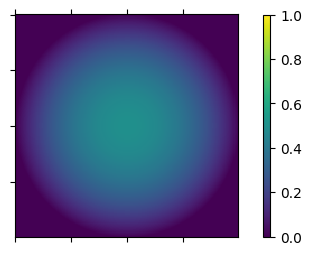

In [13]:
max_lattice_filling = 0.5
r_max = 100

distribution = generate_radial_distribution(max_lattice_filling, r_max)

result = prob_mat(distribution, (2*r_max, 2*r_max), samples=1, ax=1, ay=1, polar=True)

fig, ax = plt.subplots()

ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)
ax.set_xticks([])
ax.set_yticks([])

cax = ax.matshow(result)
cax.set_clim(0, 1)
cbar = fig.colorbar(cax, location="right", 
        shrink=0.6,
        aspect=30,
        fraction=0.5)

plt.savefig(f'discrete_lattice_dist.pdf', bbox_inches='tight')

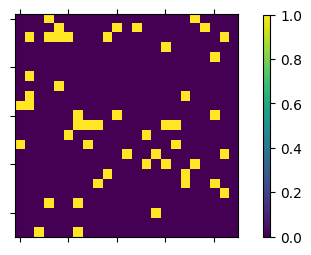

In [33]:
sample_config = unif_random_config(0.1, 50)

fig, ax = plt.subplots()

ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)
ax.set_xticks([])
ax.set_yticks([])

cax = ax.matshow(sample_config)
cax.set_clim(0, 1)
cbar = fig.colorbar(cax, location="right", 
        shrink=0.6,
        aspect=30,
        fraction=0.5)
plt.savefig(f'Example_uniform_lattice.png', bbox_inches='tight')

In [17]:
norm = 0
for i in sample_config:
    for n in i:
        norm += n

print('Number of particles: ' + str(norm))

no = [[1]]
pair = [[1, 1]]
diag_pair = [[1, 0], [0, 1]]
triangle = [[1, 1], [1, 0]]
chain_3 = [[1, 1, 1]]
chain_4 = [[1, 1, 1, 1]]

def find_geometries(discrete_dist, samples):
    no = [[1]]
    pair = [[0, 0, 0, 0], [0, 1, 1, 0], [0, 0, 0, 0]]
    diag_pair = [[0, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 0]]
    triangle = [[0, 0, 0, 0], [0, 1, 1, 0], [0, 1, 0, 0], [0, 0, 0, 0]]
    chain_3 = [[0, 0, 0, 0, 0], [0, 1, 1, 1, 0], [0, 0, 0, 0, 0]]
    chain_4 = [[0, 0, 0, 0, 0, 0], [0, 1, 1, 1, 1, 0], [0, 0, 0, 0, 0, 0]]

    particle_no, pair_no, diag_pair_no, triangle_no, chain_3_no, chain_4_no = [], [], [], [], [], []
    for i in range(samples):
        sample_config = random_config(discrete_dist)
        sample_config = np.pad(sample_config, ((1, 1), (1, 1)), 'constant', constant_values=((0, 0), (0, 0)))
        particle_no.append(pattern_search(sample_config, no, symmetrical=True)/2)
        pair_no.append(pattern_search(sample_config, pair, symmetrical=True))
        diag_pair_no.append(pattern_search(sample_config, diag_pair, symmetrical=True, particle_no=2))
        triangle_no.append(pattern_search(sample_config, triangle, particle_no=3))
        chain_3_no.append(pattern_search(sample_config, chain_3, symmetrical=True, particle_no=3))
        chain_4_no.append(pattern_search(sample_config, chain_4, symmetrical=True))

    # returns list of averages and list of standard deviations
    return np.array([np.mean(particle_no), np.mean(pair_no), np.mean(diag_pair_no), np.mean(triangle_no), np.mean(chain_3_no), np.mean(chain_4_no)]), [np.std(particle_no), np.std(pair_no), np.std(diag_pair_no), np.std(triangle_no), np.std(chain_3_no), np.std(chain_4_no)]

averages, standard_deviations = unif_find_geometries(0.5, 12, 10)
print(averages)
print('Number of particles, Number of pairs, Number of diagonal pairs, Number of triangles, Number of 3 particle chains, Number of 4 particle chains')



Number of particles: 12.0
[12.          0.01666667  0.          0.          0.          0.025
  0.        ]
Number of particles, Number of pairs, Number of diagonal pairs, Number of triangles, Number of 3 particle chains, Number of 4 particle chains


<ErrorbarContainer object of 3 artists>

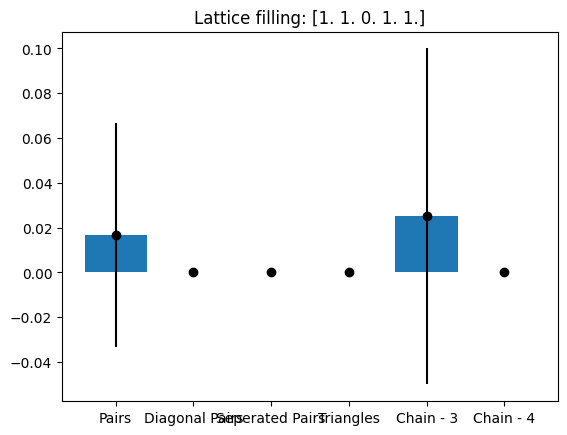

In [19]:
labels = ['Particle number', 'Pairs', 'Diagonal Pairs', 'Seperated Pairs', 'Triangles', 'Chain - 3', 'Chain - 4']

fig, ax = plt.subplots()
ax.set_title('Lattice filling: ' + str(i))
ax.bar(labels[1:], averages[1:])
ax.errorbar(labels[1:], averages[1:], yerr=standard_deviations[1:], color='black', fmt='o')

In [84]:
a = np.array([[1, 2, 3], 
     [4, 5, 6]])
print(a)
print(rotated(rotated(a)))
for i in range(4):
    print(i)

[[1 2 3]
 [4 5 6]]
[[np.int64(6), np.int64(5), np.int64(4)], [np.int64(3), np.int64(2), np.int64(1)]]
0
1
2
3


In [41]:

lat_fils = np.linspace(0.001, 0.5, 100)
N_per_sample = 10000
r_max = 100
iterations = 100
labels = ['Particle number', 'Pairs', 'Diagonal Pairs', 'Seperated Pairs', 'Triangles', 'Chain - 3', 'Chain - 4']


all_avg, all_std = [], []
for i in lat_fils:
        averages, standard_deviations = unif_find_geometries(i, N_per_sample, iterations)
        all_avg.append(averages[1:])
        all_std.append(standard_deviations[1:])
        print('Done: ' + str(i))

all_avg, all_std = np.array(all_avg), np.array(all_std)

Done: 0.001
Done: 0.0060404040404040404
Done: 0.01108080808080808
Done: 0.016121212121212123
Done: 0.021161616161616163
Done: 0.026202020202020202
Done: 0.031242424242424245
Done: 0.036282828282828285
Done: 0.041323232323232324
Done: 0.046363636363636364
Done: 0.0514040404040404
Done: 0.05644444444444444
Done: 0.06148484848484849
Done: 0.06652525252525253
Done: 0.07156565656565657
Done: 0.07660606060606061
Done: 0.08164646464646465
Done: 0.08668686868686869
Done: 0.09172727272727273
Done: 0.09676767676767677
Done: 0.1018080808080808
Done: 0.10684848484848485
Done: 0.11188888888888888
Done: 0.11692929292929292
Done: 0.12196969696969698
Done: 0.12701010101010102
Done: 0.13205050505050506
Done: 0.1370909090909091
Done: 0.14213131313131314
Done: 0.14717171717171718
Done: 0.15221212121212122
Done: 0.15725252525252525
Done: 0.1622929292929293
Done: 0.16733333333333333
Done: 0.17237373737373737
Done: 0.1774141414141414
Done: 0.18245454545454545
Done: 0.1874949494949495
Done: 0.192535353535353

In [37]:
from matplotlib import gridspec
import scipy.optimize
from scipy.special import factorial

##########################################################################################################
def normal(x, vals):
        return vals[0]*((1-x)**(vals[1]))*(x**(vals[2]))

def gen_norm(vals):
    def nor(x):
        return vals[0]*((1-x)**(vals[1]))*(x**(vals[2]))
    return nor
##########################################################################################################


def poisson(x, vals):                  #vals is mu then coefficient
    x = x*vals[3] + vals[2]
    return vals[1]*np.exp(-vals[0])*(vals[0]**x)/factorial(x)

def gen_poi(vals):
    def poi(x):                  #vals is mu then coefficient
        x = x*vals[3] + vals[2]
        return vals[1]*np.exp(-vals[0])*(vals[0]**x)/factorial(x)
    return poi

def gen_chisq(model_funct):
    def chi(modelparams, x_data, y_data, y_err):
        chisqval=0
        for i in range(len(x_data)):
            chisqval += ((y_data[i] - model_funct(x_data[i], modelparams))/y_err[i])**2
        return chisqval
    return chi

labels = ['Particle number', 'Pairs', 'Diagonal Pairs', 'Seperated Pairs', 'Triangles', 'Chain - 3', 'Chain - 4']
    
chisq = gen_chisq(normal)

Desired error not necessarily achieved due to precision loss.
[3.19104646 9.02423404 0.94445251]
Optimization terminated successfully.
[ 3.14487601 12.93230477  0.94252617]
Optimization terminated successfully.
[ 3.3982863  12.07713544  0.96600778]
Desired error not necessarily achieved due to precision loss.
[ 7.44004908 11.4572111   1.86578934]
Optimization terminated successfully.
[ 3.21712072 10.17250653  1.8245862 ]
Optimization terminated successfully.
[ 1.81751758 10.54776707  2.5181967 ]


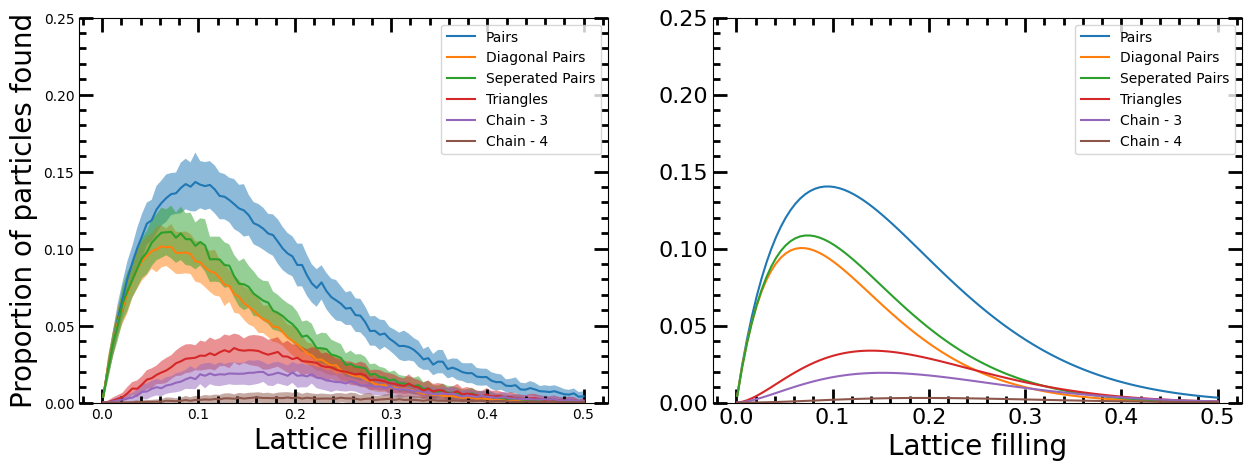

In [39]:
fig = plt.figure(figsize=(15, 5))
spec = gridspec.GridSpec(ncols=2, nrows=1,
                         width_ratios=[1, 1])
axes = fig.add_subplot(spec[0])
ax2 = fig.add_subplot(spec[1])
initial = np.array([3.5, 8, 1])
const_error = 0.01*np.ones(100)

coefficients = []
for i in range(len(labels[1:])):

    ys, error = np.transpose(all_avg)[i], np.transpose(all_std)[i]
    
    axes.plot(lat_fils, ys, label=labels[i + 1])
    
    axes.fill_between(lat_fils, ys-error, ys+error, alpha=0.5)    
    #for i in range(5):
        #print(populations[:,1][100*i])
    fit = scipy.optimize.minimize(chisq, initial, args=(lat_fils, ys, const_error))
    print(fit.message)
    print(fit.x)
    coefficients.append([fit.x, labels[i + 1]])

    model = gen_norm(fit.x)
    #model = gen_norm(initial)
    #print(model(0.12))
    modelled_data = model(lat_fils)

    ax2.plot(lat_fils, modelled_data, label=labels[i + 1])

axes.set_xlabel(r"Lattice filling", fontsize=20)
ax2.set_xlabel(r"Lattice filling", fontsize=20)
axes.set_ylabel('Proportion of particles found', fontsize=20)

axes.minorticks_on()
axes.tick_params(which='major', length=10, width=2, direction='in', bottom=True, top=True, left=True, right=True)
axes.tick_params(which='minor', length=5, width=2, direction='in', bottom=True, top=True, left=True, right=True)
ax2.minorticks_on()
ax2.tick_params(which='major', length=10, width=2, direction='in', bottom=True, top=True, left=True, right=True)
ax2.tick_params(which='minor', length=5, width=2, direction='in', bottom=True, top=True, left=True, right=True)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
axes.legend(loc=1)
ax2.legend(loc=1)
axes.set_ylim([0, 0.25])
ax2.set_ylim([0, 0.25])


plt.savefig(f'FULL_small_geometry_graph.pdf', bbox_inches='tight')
plt.show(block=False)

In [357]:
intervals = 200
holds = np.linspace(0, 350 * pulse_time, intervals)


particles_per_sample = 12
J, det, ax, ay = 1200, 0, 1, 1
theta, phi = 0, 0



In [383]:
# PAIR

up_probabilities = []
progress = 0
particles = 2
v0 = np.zeros(2**particles)
v0[-1] = 1

for i in holds:
    #time = [0, pulse_time, pulse_time + i, 2*pulse_time + i]
    time = np.linspace(0, 2*pulse_time + i, 2)
    params = [pulse_time, i, rabi_frequency]

    Hamiltonian = construct_H(particles, J, det, ax, ay, particles, params, pulse_ramsey, theta=theta, phi=phi, Ly=1)
    populations = Hamiltonian.evolve(v0, 0, time)
    ups = sparse_up_prob(particles, particles, 1, populations)
    up_probabilities.append(ups[-1])
    progress += 1
    print(str(progress) + '/' + str(intervals) + ' Done')
PAIR = np.array(up_probabilities)


/var/folders/ln/c_qknrr51xbgxcyyp59605kr0000gn/T/ipykernel_33129/4166665165.py:32: RuntimeWarning: invalid value encountered in scalar divide
  angle = np.arccos(displacement @ quan_axis/r)


Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
1/200 Done
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
2/200 Done
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
3/200 Done
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
4/200 Done
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
5/200 Done
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
6/200 Done
Hermiticity check passed!
Symmetry

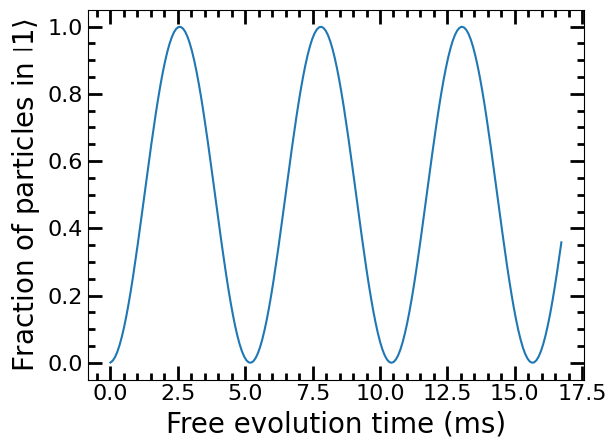

In [385]:
fig, axes = plt.subplots(1, 1)

axes.plot(holds*(10**3), PAIR)
        
    #for i in range(5):
        #print(populations[:,1][100*i])

axes.set_ylabel(r"Fraction of particles in $\left|1\right>$", fontsize=20)
axes.set_xlabel('Free evolution time (ms)', fontsize=20)

axes.minorticks_on()
axes.tick_params(which='major', length=10, width=2, direction='in', bottom=True, top=True, left=True, right=True)
axes.tick_params(which='minor', length=5, width=2, direction='in', bottom=True, top=True, left=True, right=True)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
    
plt.show(block=False)

In [387]:
# DIAGONAL PAIR

up_probabilities = []
progress = 0
particles = 2
v0 = np.zeros(2**particles)
v0[-1] = 1
diag_seperation = np.sqrt(2)

for i in holds:
    #time = [0, pulse_time, pulse_time + i, 2*pulse_time + i]
    time = np.linspace(0, 2*pulse_time + i, 2)
    params = [pulse_time, i, rabi_frequency]

    Hamiltonian = construct_H(particles, J, det, diag_seperation, ay, particles, params, pulse_ramsey, theta=theta, phi=phi, Ly=1)
    populations = Hamiltonian.evolve(v0, 0, time)
    ups = sparse_up_prob(particles, particles, 1, populations)
    up_probabilities.append(ups[-1])
    progress += 1
    print(str(progress) + '/' + str(intervals) + ' Done')
DIAG_PAIR = np.array(up_probabilities)

/var/folders/ln/c_qknrr51xbgxcyyp59605kr0000gn/T/ipykernel_33129/4166665165.py:32: RuntimeWarning: invalid value encountered in scalar divide
  angle = np.arccos(displacement @ quan_axis/r)


Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
1/200 Done
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
2/200 Done
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
3/200 Done
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
4/200 Done
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
5/200 Done
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
6/200 Done
Hermiticity check passed!
Symmetry

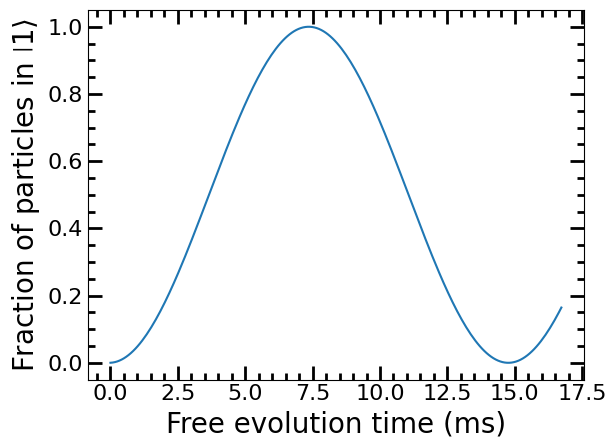

In [389]:
fig, axes = plt.subplots(1, 1)

axes.plot(holds*(10**3), DIAG_PAIR)
        
    #for i in range(5):
        #print(populations[:,1][100*i])

axes.set_ylabel(r"Fraction of particles in $\left|1\right>$", fontsize=20)
axes.set_xlabel('Free evolution time (ms)', fontsize=20)

axes.minorticks_on()
axes.tick_params(which='major', length=10, width=2, direction='in', bottom=True, top=True, left=True, right=True)
axes.tick_params(which='minor', length=5, width=2, direction='in', bottom=True, top=True, left=True, right=True)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
    
plt.show(block=False)

In [391]:
# SEPERATED PAIR

up_probabilities = []
progress = 0
particles = 2
v0 = np.zeros(2**particles)
v0[-1] = 1
sep_pair_seperation = 1

for i in holds:
    #time = [0, pulse_time, pulse_time + i, 2*pulse_time + i]
    time = np.linspace(0, 2*pulse_time + i, 5)
    params = [pulse_time, i, rabi_frequency]

    Hamiltonian = construct_H(particles, J/8, det, sep_pair_seperation, ay, particles, params, pulse_ramsey, theta=theta, phi=phi, Ly=1)
    populations = Hamiltonian.evolve(v0, 0, time)
    ups = sparse_up_prob(particles, particles, 1, populations)
    up_probabilities.append(ups[-1])
    progress += 1
    print(str(progress) + '/' + str(intervals) + ' Done')
SEP_PAIR = np.array(up_probabilities)

/var/folders/ln/c_qknrr51xbgxcyyp59605kr0000gn/T/ipykernel_33129/4166665165.py:32: RuntimeWarning: invalid value encountered in scalar divide
  angle = np.arccos(displacement @ quan_axis/r)


Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
1/200 Done
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
2/200 Done
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
3/200 Done
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
4/200 Done
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
5/200 Done
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
6/200 Done
Hermiticity check passed!
Symmetry

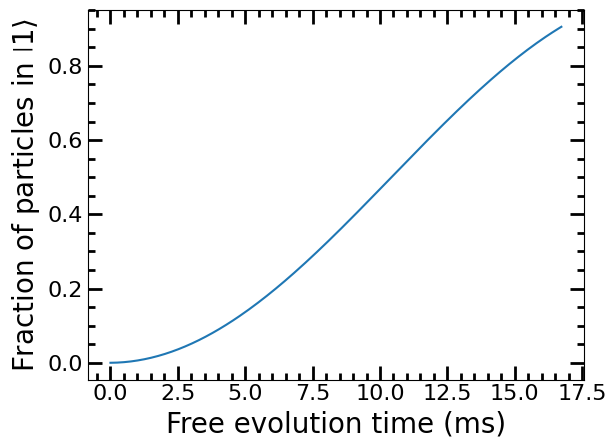

In [392]:
fig, axes = plt.subplots(1, 1)

axes.plot(holds*(10**3), SEP_PAIR)
        
    #for i in range(5):
        #print(populations[:,1][100*i])

axes.set_ylabel(r"Fraction of particles in $\left|1\right>$", fontsize=20)
axes.set_xlabel('Free evolution time (ms)', fontsize=20)

axes.minorticks_on()
axes.tick_params(which='major', length=10, width=2, direction='in', bottom=True, top=True, left=True, right=True)
axes.tick_params(which='minor', length=5, width=2, direction='in', bottom=True, top=True, left=True, right=True)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
    
plt.show(block=False)

In [395]:
# TRIANGLE

up_probabilities = []
progress = 0
particles = 3
v0 = np.zeros(2**particles)
v0[-1] = 1

for i in holds:
    #time = [0, pulse_time, pulse_time + i, 2*pulse_time + i]
    time = np.linspace(0, 2*pulse_time + i, 2)
    params = [pulse_time, i, rabi_frequency]

    Hamiltonian = construct_H(particles, J, det, ax, ay, 2, params, pulse_ramsey, theta=theta, phi=phi, Ly=2)
    populations = Hamiltonian.evolve(v0, 0, time)
    ups = sparse_up_prob(particles, particles, 1, populations)
    up_probabilities.append(ups[-1])
    progress += 1
    print(str(progress) + '/' + str(intervals) + ' Done')
TRIANGLE = np.array(up_probabilities)

/var/folders/ln/c_qknrr51xbgxcyyp59605kr0000gn/T/ipykernel_33129/4166665165.py:32: RuntimeWarning: invalid value encountered in scalar divide
  angle = np.arccos(displacement @ quan_axis/r)


Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
1/200 Done
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
2/200 Done
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
3/200 Done
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
4/200 Done
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermit

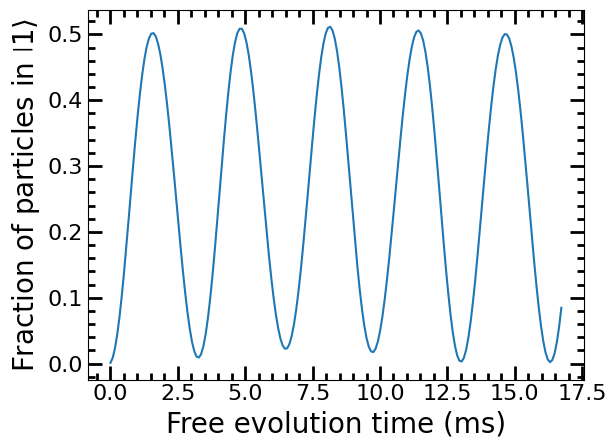

In [396]:
fig, axes = plt.subplots(1, 1)

axes.plot(holds*(10**3), TRIANGLE)
        
    #for i in range(5):
        #print(populations[:,1][100*i])

axes.set_ylabel(r"Fraction of particles in $\left|1\right>$", fontsize=20)
axes.set_xlabel('Free evolution time (ms)', fontsize=20)

axes.minorticks_on()
axes.tick_params(which='major', length=10, width=2, direction='in', bottom=True, top=True, left=True, right=True)
axes.tick_params(which='minor', length=5, width=2, direction='in', bottom=True, top=True, left=True, right=True)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
    
plt.show(block=False)

In [399]:
# CHAIN 3

up_probabilities = []
progress = 0
particles = 3
v0 = np.zeros(2**particles)
v0[-1] = 1

for i in holds:
    #time = [0, pulse_time, pulse_time + i, 2*pulse_time + i]
    time = np.linspace(0, 2*pulse_time + i, 2)
    params = [pulse_time, i, rabi_frequency]

    Hamiltonian = construct_H(particles, J, det, ax, ay, particles, params, pulse_ramsey, theta=theta, phi=phi, Ly=1)
    populations = Hamiltonian.evolve(v0, 0, time)
    ups = sparse_up_prob(particles, particles, 1, populations)
    up_probabilities.append(ups[-1])
    progress += 1
    print(str(progress) + '/' + str(intervals) + ' Done')
CHAIN_3 = np.array(up_probabilities)

/var/folders/ln/c_qknrr51xbgxcyyp59605kr0000gn/T/ipykernel_33129/4166665165.py:32: RuntimeWarning: invalid value encountered in scalar divide
  angle = np.arccos(displacement @ quan_axis/r)


Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
1/200 Done
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
2/200 Done
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
3/200 Done
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
4/200 Done
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermit

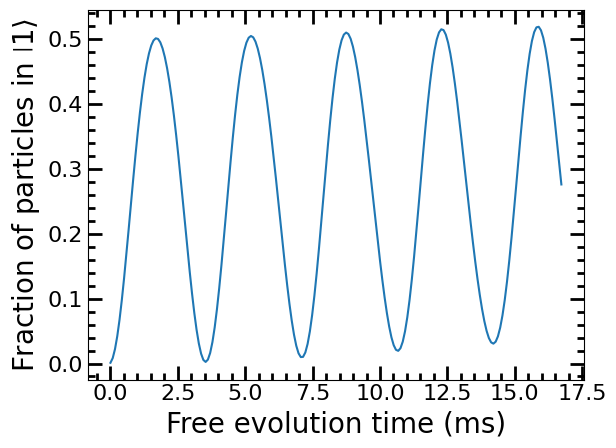

In [400]:
fig, axes = plt.subplots(1, 1)

axes.plot(holds*(10**3), CHAIN_3)
        
    #for i in range(5):
        #print(populations[:,1][100*i])

axes.set_ylabel(r"Fraction of particles in $\left|1\right>$", fontsize=20)
axes.set_xlabel('Free evolution time (ms)', fontsize=20)

axes.minorticks_on()
axes.tick_params(which='major', length=10, width=2, direction='in', bottom=True, top=True, left=True, right=True)
axes.tick_params(which='minor', length=5, width=2, direction='in', bottom=True, top=True, left=True, right=True)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
    
plt.show(block=False)

In [401]:
# CHAIN 4

up_probabilities = []
progress = 0
particles = 4
v0 = np.zeros(2**particles)
v0[-1] = 1

for i in holds:
    #time = [0, pulse_time, pulse_time + i, 2*pulse_time + i]
    time = np.linspace(0, 2*pulse_time + i, 2)
    params = [pulse_time, i, rabi_frequency]

    Hamiltonian = construct_H(particles, J, det, ax, ay, particles, params, pulse_ramsey, theta=theta, phi=phi, Ly=1)
    populations = Hamiltonian.evolve(v0, 0, time)
    ups = sparse_up_prob(particles, particles, 1, populations)
    up_probabilities.append(ups[-1])
    progress += 1
    print(str(progress) + '/' + str(intervals) + ' Done')
CHAIN_4 = np.array(up_probabilities)

Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
1/200 Done
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
2/200 Done
Hermiticity check passed!
Symmetry checks passed!


/var/folders/ln/c_qknrr51xbgxcyyp59605kr0000gn/T/ipykernel_33129/4166665165.py:32: RuntimeWarning: invalid value encountered in scalar divide
  angle = np.arccos(displacement @ quan_axis/r)


Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
3/200 Done
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
4/200 Done
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
5/200 Done
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
6/200 Done
Hermit

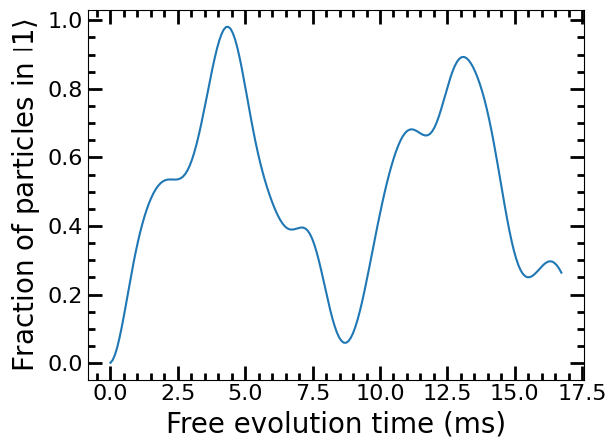

In [404]:
fig, axes = plt.subplots(1, 1)

axes.plot(holds*(10**3), CHAIN_4)
        
    #for i in range(5):
        #print(populations[:,1][100*i])

axes.set_ylabel(r"Fraction of particles in $\left|1\right>$", fontsize=20)
axes.set_xlabel('Free evolution time (ms)', fontsize=20)

axes.minorticks_on()
axes.tick_params(which='major', length=10, width=2, direction='in', bottom=True, top=True, left=True, right=True)
axes.tick_params(which='minor', length=5, width=2, direction='in', bottom=True, top=True, left=True, right=True)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
    
plt.show(block=False)

In [413]:
print(coefficients)
print(coefficients[1][0])

[[array([0.09831883, 0.28114286, 0.15244977]), 'Pairs'], [array([0.07803636, 0.20747506, 0.10057684]), 'Diagonal Pairs'], [array([0.08414337, 0.22261399, 0.10884819]), 'Seperated Pairs'], [array([0.14202449, 0.24655381, 0.03630905]), 'Triangles'], [array([0.1484297 , 0.28560682, 0.02106892]), 'Chain - 3'], [array([-0.30547858,  0.05971461, -2.15074999]), 'Chain - 4']]
[0.07803636 0.20747506 0.10057684]


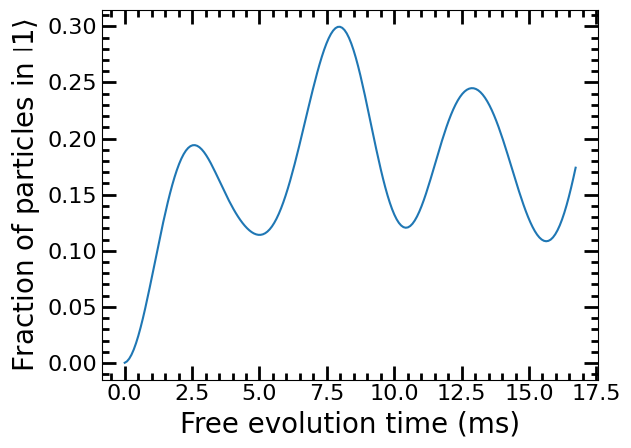

In [425]:
p, dp, sp, t, c3, c4 = gen_norm(coefficients[0][0]), gen_norm(coefficients[1][0]), gen_norm(coefficients[2][0]), gen_norm(coefficients[3][0]), gen_norm(coefficients[4][0]), gen_norm(coefficients[5][0])

lat_filling = 0.1

TOTAL = p(lat_filling)*PAIR + dp(lat_filling)*DIAG_PAIR + sp(lat_filling)*SEP_PAIR + t(lat_filling)*TRIANGLE + c3(lat_filling)*CHAIN_3 + c4(lat_filling)*CHAIN_4


fig, axes = plt.subplots(1, 1)

axes.plot(holds*(10**3), TOTAL)
        
    #for i in range(5):
        #print(populations[:,1][100*i])

axes.set_ylabel(r"Fraction of particles in $\left|1\right>$", fontsize=20)
axes.set_xlabel('Free evolution time (ms)', fontsize=20)

axes.minorticks_on()
axes.tick_params(which='major', length=10, width=2, direction='in', bottom=True, top=True, left=True, right=True)
axes.tick_params(which='minor', length=5, width=2, direction='in', bottom=True, top=True, left=True, right=True)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
    
plt.show(block=False)

/opt/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


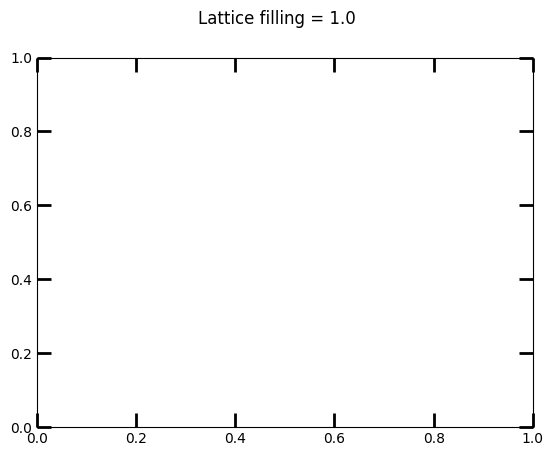

In [475]:
# animation
from matplotlib.animation import PillowWriter
fillings = np.concatenate((np.linspace(0.001, 0.35, 150), np.linspace(0.35, 1, 65)))

metadata = dict(title='Movie', artist='codinglikemad')
writer = PillowWriter(fps=24, metadata=metadata)

fig, ax = plt.subplots()

with writer.saving(fig, f'CONSTRUCTED_unif_ramsey_fringes.gif', 100):
    for i in fillings:
        lat_filling = i
        TOTAL = p(lat_filling)*PAIR + dp(lat_filling)*DIAG_PAIR + sp(lat_filling)*SEP_PAIR + t(lat_filling)*TRIANGLE + c3(lat_filling)*CHAIN_3 + c4(lat_filling)*CHAIN_4


        
        ax.plot(holds*(10**3), TOTAL)
        
        #for i in range(5):
            #print(populations[:,1][100*i])


        yticks = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
        ax.set_yticks(yticks)
        ax.set_ylabel(r"Fraction of particles in $\left|1\right>$", fontsize=20)
        ax.set_xlabel('Free evolution time (ms)', fontsize=20)
        fig.suptitle('Lattice filling = ' + str(i)[0:4])
    
        ax.minorticks_on()
        ax.tick_params(which='major', length=10, width=2, direction='in', bottom=True, top=True, left=True, right=True)
        ax.tick_params(which='minor', length=5, width=2, direction='in', bottom=True, top=True, left=True, right=True)
        plt.yticks(fontsize=16)
        plt.xticks(fontsize=16)
        
        
        writer.grab_frame()
        ax.clear()

In [451]:
def ensemble_Ramsey(samples, time, p_max, r_max, initial_state, N, J, det, ax, ay, params, pulse, theta=0, phi=0):
    results = []
    for i in range(samples):
        #r = random.randint(0, int(3000*r_max/4))/1000
        #p = p_max*(1 - (r/r_max)**2)a
        #side_length = int(np.sqrt(N/p))+1
        #print(side_length)
        #side_length = 2
        side_length = int(np.sqrt(N/p_max))+1
        Hamiltonian = construct_H(N, J, det, ax, ay, side_length, params, pulse, theta=theta, phi=phi, Ly=side_length)
        populations = Hamiltonian.evolve(initial_state, 0, time)
        ups = sparse_up_prob(N, side_length, side_length, populations)
        results.append(ups[-1])
        #print('Sample ' + str(i) + ' completed')
    return sum(results)/samples

In [453]:


intervals = 200
holds = np.linspace(0, 350 * pulse_time, intervals)
samples = 10

particles_per_sample = 12
J, det, ax, ay = 1200, 0, 1, 1
p_max, r_max = 0.1, 1000
theta, phi = 0, 0

initial_state = np.zeros(2**particles_per_sample)
initial_state[-1] = 1

up_probabilities = []
progress = 0
for i in holds:
    #time = [0, pulse_time, pulse_time + i, 2*pulse_time + i]
    times2 = np.linspace(0, 2*pulse_time + i, 2)
    params = [pulse_time, i, rabi_frequency]
    up_probabilities.append(ensemble_Ramsey(samples, times2, p_max, r_max, initial_state, particles_per_sample, J, det, ax, ay, params, pulse_ramsey, theta=theta, phi=phi))
    progress += 1
    print(str(progress) + '/' + str(intervals) + ' Done')

/var/folders/ln/c_qknrr51xbgxcyyp59605kr0000gn/T/ipykernel_33129/4166665165.py:32: RuntimeWarning: invalid value encountered in scalar divide
  angle = np.arccos(displacement @ quan_axis/r)


Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


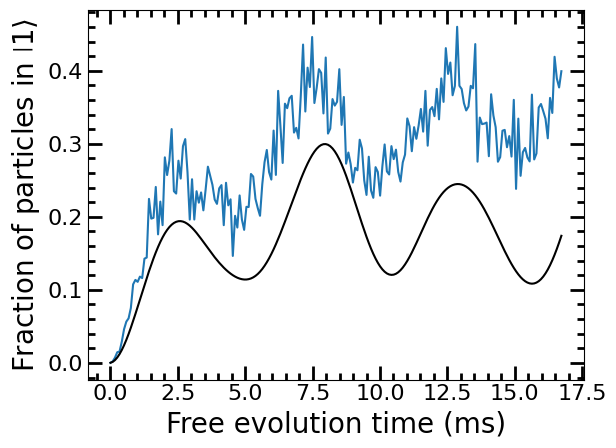

In [473]:
fig, axes = plt.subplots(1, 1)

axes.plot(holds*(10**3), up_probabilities)
        
    #for i in range(5):
        #print(populations[:,1][100*i])

axes.set_ylabel(r"Fraction of particles in $\left|1\right>$", fontsize=20)
axes.set_xlabel('Free evolution time (ms)', fontsize=20)

lat_filling = p_max 
TOTAL = p(lat_filling)*PAIR + dp(lat_filling)*DIAG_PAIR + sp(lat_filling)*SEP_PAIR + t(lat_filling)*TRIANGLE + c3(lat_filling)*CHAIN_3 + c4(lat_filling)*CHAIN_4

axes.plot(holds*(10**3), TOTAL, color='black')

axes.minorticks_on()
axes.tick_params(which='major', length=10, width=2, direction='in', bottom=True, top=True, left=True, right=True)
axes.tick_params(which='minor', length=5, width=2, direction='in', bottom=True, top=True, left=True, right=True)
yticks = np.linspace(0, 0.35, 8)
#axes.set_yticks(yticks) 
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.savefig(f'uniform_CONPARISON_{particles_per_sample}_Particle_Ramsey_{J}Hz_{p_max}_filling.png', bbox_inches='tight')
    
plt.show(block=False)

In [477]:
print(coefficients)

[[array([0.09831883, 0.28114286, 0.15244977]), 'Pairs'], [array([0.07803636, 0.20747506, 0.10057684]), 'Diagonal Pairs'], [array([0.08414337, 0.22261399, 0.10884819]), 'Seperated Pairs'], [array([0.14202449, 0.24655381, 0.03630905]), 'Triangles'], [array([0.1484297 , 0.28560682, 0.02106892]), 'Chain - 3'], [array([-0.30547858,  0.05971461, -2.15074999]), 'Chain - 4']]
